# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/validation/'

L_rate=0.001
BATCH_SIZE=32
epoch=15


Device= 'cuda'
Model_name='efficientnet_b0'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_ogms = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])


valid_ogms = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor()
])

In [ ]:
trainset = ImageFolder( TRAIN_IMG_FOLDER_PATH, transform = train_ogms )
validset = ImageFolder( VALID_IMG_FOLDER_PATH, transform = valid_ogms )

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, 'angry')

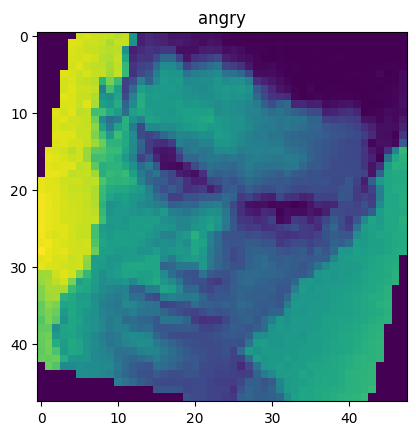

In [ ]:
image, label = trainset[50]
class_name = trainset.classes[label]

plt.imshow(image.permute(1,2,0))
plt.title(class_name)

This becomes shape [48, 48, 1], which is a single-channel image, but imshow() still applies a default colormap (usually 'viridis') to visualize the intensity values as pseudo-color.

This is just a visualization trick, not actual color in the image.

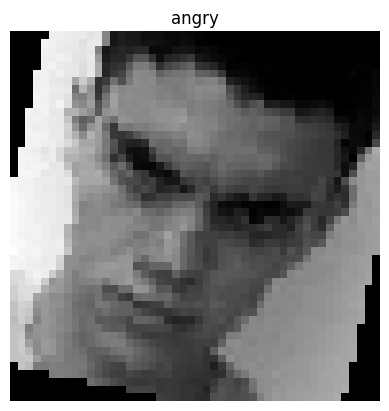

In [ ]:
plt.imshow(image.squeeze(0), cmap='gray')  # squeeze to [48, 48]
plt.title(class_name)
plt.axis('off')
plt.show()


# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader( trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader( validset, batch_size = BATCH_SIZE )

In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader :
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 1, 48, 48])
One label batch shape : torch.Size([32])


In [ ]:
import os

base_path = "/content/Facial-Expression-Dataset"
print("Folders:", os.listdir(base_path))


Folders: ['train', 'validation', '.git']


In [ ]:
train_path = os.path.join(base_path, "train")
print("Emotion folders:", os.listdir(train_path))


Emotion folders: ['disgust', 'happy', 'sad', 'fear', 'neutral', 'angry', 'surprise']


In [ ]:
happy_path = os.path.join(train_path, "happy")
print("Example files:", os.listdir(happy_path)[:5])


Example files: ['23383.jpg', '26671.jpg', '26068.jpg', '19343.jpg', '7942.jpg']


In [ ]:
from PIL import Image

image_path = os.path.join(happy_path, '8652.jpg')  # Use an actual filename from above
img = Image.open(image_path)

print("Image mode:", img.mode)  # Should be 'L' or 'RGB'


Image mode: L


# Create Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):  # 7 emotions
        super(EmotionResNet, self).__init__()

        # Load pretrained ResNet18
        self.model = models.resnet18(pretrained=True)

        # Modify the first convolution layer to accept 1-channel (grayscale) input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace the fully connected layer with your classifier
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
model = EmotionResNet()
model.to(Device);

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    epoch_loss = running_loss / total_preds
    epoch_acc = correct_preds / total_preds
    return epoch_loss, epoch_acc


# Create Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EmotionResNet(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, validloader, criterion, device)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Epoch 1/10
  Train Loss: 1.7043 | Train Acc: 0.3159
  Val   Loss: 1.5354 | Val   Acc: 0.3869
Epoch 2/10
  Train Loss: 1.5834 | Train Acc: 0.3757
  Val   Loss: 1.7062 | Val   Acc: 0.2983
Epoch 3/10
  Train Loss: 1.5192 | Train Acc: 0.3983
  Val   Loss: 1.4863 | Val   Acc: 0.4140
Epoch 4/10
  Train Loss: 1.4797 | Train Acc: 0.4168
  Val   Loss: 1.4363 | Val   Acc: 0.4379
Epoch 5/10
  Train Loss: 1.4371 | Train Acc: 0.4458
  Val   Loss: 1.3213 | Val   Acc: 0.4929
Epoch 6/10
  Train Loss: 1.3955 | Train Acc: 0.4636
  Val   Loss: 1.2876 | Val   Acc: 0.5139
Epoch 7/10
  Train Loss: 1.3575 | Train Acc: 0.4824
  Val   Loss: 1.2430 | Val   Acc: 0.5205
Epoch 8/10
  Train Loss: 1.3377 | Train Acc: 0.4869
  Val   Loss: 1.2329 | Val   Acc: 0.5269
Epoch 9/10
  Train Loss: 1.3106 | Train Acc: 0.5035
  Val   Loss: 1.2493 | Val   Acc: 0.5188
Epoch 10/10
  Train Loss: 1.3009 | Train Acc: 0.5106
  Val   Loss: 1.2207 | Val   Acc: 0.5342


# Inference

In [ ]:
import matplotlib.pyplot as plt

def view_classify(img, ps):
    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().squeeze()  # Make it [48, 48] for grayscale

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img, cmap='gray')  # Show in grayscale
    ax1.axis('off')

    y_pos = range(len(classes))
    ax2.barh(y_pos, ps, color='skyblue')
    ax2.set_aspect(0.1)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    # Add percentage text labels next to the bars
    for i, p in enumerate(ps):
        ax2.text(p + 0.01, i, f"{p * 100:.2f}%", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()


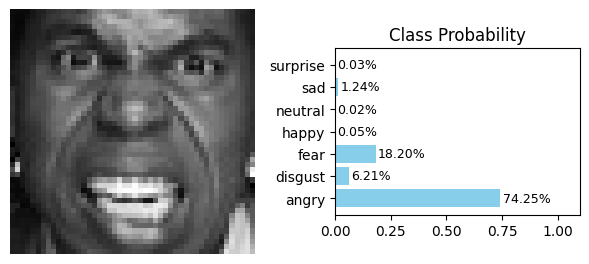

In [ ]:
dataiter = iter(validloader)
images, labels = next(dataiter)

img = images[19]
label = labels[19]

# Make prediction
model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))  # add batch dimension
    ps = torch.nn.functional.softmax(output, dim=1)

# Visualize
view_classify(img.cpu(), ps)
